In [1]:
%pip install -r requirements.txt --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(rc={'figure.figsize':(10,8)})
sns.set_palette("bright")

Note: you may need to restart the kernel to use updated packages.


In [42]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

data_home = "./Data/"


def load_dataset_train_test():
    data_train = fetch_20newsgroups(
        data_home=data_home,
        subset="train",
        shuffle=True,
        random_state=42,
        remove=('headers', 'footers', 'quotes')
    )

    data_test = fetch_20newsgroups(
        data_home=data_home,
        subset="test",
        shuffle=True,
        random_state=42,
        remove=('headers', 'footers', 'quotes')
    )

    target_names = data_train.target_names
    y_train, y_test = data_train.target, data_test.target

    vectorizer = TfidfVectorizer(max_df=0.5, min_df=5, stop_words="english")

    X_train = vectorizer.fit_transform(data_train.data)
    X_test = vectorizer.transform(data_test.data)
    feature_names = vectorizer.get_feature_names_out()

    return X_train, X_test, y_train, y_test, feature_names, target_names, vectorizer


def load_dataset():
    data = fetch_20newsgroups(
        data_home=data_home, subset="all", shuffle=False, remove=('headers', 'footers', 'quotes')
    )
    y = data.target
    target_names = data.target_names
    vectorizer = TfidfVectorizer(max_df=0.5, min_df=5, stop_words="english")
    X = vectorizer.fit_transform(data.data)
    feature_names = vectorizer.get_feature_names_out()
    return X, y, feature_names, target_names, vectorizer

def twenty_newsgroup_to_csv(save_target: bool = False):
    data = fetch_20newsgroups(
        data_home=data_home, subset="all", shuffle=False, remove=('headers', 'footers', 'quotes')
    )

    if not save_target:
        df = pd.DataFrame([data.data]).T
        df.columns = ['text']
        df.to_csv(data_home + '20_newsgroup.csv', index=False)
        return 
        
    df = pd.DataFrame([data.data, data.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame( data.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out.to_csv(data_home + '20_newsgroup.csv', index=False)
    
twenty_newsgroup_to_csv(save_target=False)

In [43]:
# X_train, X_test, y_train, y_test, feature_names, target_names, vectorizer = load_dataset()
X, y, feature_names, target_names , vectorizer = load_dataset()

In [4]:
target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

# LSA (SVD)

In [6]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=10)
lsa = svd.fit_transform(X)
lsa_df = pd.DataFrame(svd.components_, index=[f"topic_{i}" for i in range(1, 11)], columns=feature_names).T
lsa_df

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
00,0.028244,-0.044237,-0.057971,0.071185,0.031600,-0.092098,-0.241584,-0.076852,-0.076018,0.082129
000,0.023307,0.010337,-0.042461,0.007962,-0.007090,-0.017612,-0.042413,-0.042714,-0.061726,-0.002537
0000,0.000388,-0.000448,-0.000271,-0.000149,0.000085,-0.000814,-0.001220,-0.000283,-0.000640,0.000489
00000,0.000429,-0.001025,-0.000008,-0.000335,-0.000441,-0.001164,-0.003293,0.000121,-0.001022,0.000108
0001,0.000457,-0.000528,0.000651,-0.000436,0.000489,0.000086,0.000063,-0.000226,-0.000157,-0.000122
...,...,...,...,...,...,...,...,...,...,...
zw,0.000023,-0.000044,-0.000051,0.000064,0.000038,-0.000073,-0.000224,-0.000037,-0.000054,0.000027
zx,0.001844,-0.000356,-0.002475,0.002091,0.000771,-0.001163,0.001490,-0.000283,-0.001559,0.006193
zy,0.000032,-0.000060,-0.000065,0.000082,0.000047,-0.000103,-0.000301,-0.000045,-0.000071,0.000029
zyxel,0.000766,-0.001337,0.000110,-0.000014,-0.000178,-0.000864,-0.001179,-0.000184,0.000010,0.000999


In [8]:
def get_top_words(df, k):
    result = {}
    
    for col in df.columns:
        top_indices = df[col].nlargest(k).index.tolist() + list(reversed(df[col].nsmallest(k).index))
        formatted_entries = []
        for idx in top_indices:
            # sign = '+' if df[col][idx] >= 1e-4 else '-' if df[col][idx] <= -1e-4 else '0'
            # formatted_entries.append(f"{idx} ({sign})")
            formatted_entries.append(f"{idx} ({df[col][idx]:3.1f})")
        
        # Store in result dictionary
        result[col] = formatted_entries
    
    return pd.DataFrame(result)

lsa_top_words = get_top_words(lsa_df, 5)
display(lsa_top_words)

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,don (0.2),god (0.3),god (0.5),drive (0.4),game (0.3),windows (0.4),know (0.3),key (0.2),key (0.2),car (0.3)
1,like (0.2),people (0.2),windows (0.2),scsi (0.3),games (0.2),dos (0.2),thanks (0.3),game (0.2),geb (0.2),bike (0.2)
2,know (0.2),jesus (0.1),jesus (0.2),god (0.2),team (0.2),file (0.1),does (0.2),chip (0.2),pitt (0.2),just (0.1)
3,just (0.2),think (0.1),does (0.1),ide (0.2),thanks (0.1),think (0.1),don (0.2),encryption (0.1),dsl (0.2),god (0.1)
4,people (0.2),believe (0.1),bible (0.1),controller (0.1),windows (0.1),problem (0.1),just (0.1),clipper (0.1),cadre (0.2),good (0.1)
5,mf3t (0.0),dos (-0.1),car (-0.1),government (-0.1),chip (-0.2),does (-0.1),key (-0.1),cadre (-0.2),people (-0.1),thanks (-0.2)
6,9f3w2 (0.0),card (-0.1),games (-0.1),program (-0.1),scsi (-0.2),email (-0.1),10 (-0.1),n3jxp (-0.2),armenians (-0.1),people (-0.2)
7,m9l3 (0.0),drive (-0.2),team (-0.1),key (-0.1),government (-0.2),edu (-0.2),edu (-0.1),dsl (-0.2),israel (-0.1),drive (-0.2)
8,9l2 (0.0),thanks (-0.2),year (-0.1),file (-0.2),key (-0.2),mail (-0.2),god (-0.2),geb (-0.2),armenian (-0.1),scsi (-0.2)
9,0qq (0.0),windows (-0.2),game (-0.2),windows (-0.2),drive (-0.2),thanks (-0.3),00 (-0.2),edu (-0.2),car (-0.1),game (-0.2)


# pLSA

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger_eng', download_dir="../../.venv/", quiet=True)
# move downloaded folder to .venv/share/nltk_data

In [16]:
from plsa import Corpus, Pipeline, Visualize
from plsa.pipeline import DEFAULT_PIPELINE
from plsa.algorithms import PLSA
print(DEFAULT_PIPELINE)
plsa_pipeline = Pipeline(*DEFAULT_PIPELINE)

plsa_corpus = Corpus.from_csv(data_home + "20_newsgroup.csv", plsa_pipeline)
plsa_corpus

(<function remove_non_ascii at 0x7f61e6904900>, <function to_lower at 0x7f61e69049a0>, <function remove_numbers at 0x7f61e6904a40>, <function remove_tags.<locals>.tag_remover at 0x7f61e6904720>, <function remove_punctuation.<locals>.punctuation_remover at 0x7f61e6904860>, <function tokenize at 0x7f61e6904c20>, LemmatizeWords:
('NN',)

where:
JJ ... adjectives
VB ... verbs
NN ... nouns
RB ... adverb, RemoveStopwords:
('haven', 'd', "you'd", 'too', 'his', 've', 'doesn', 'doing', 'itself', 'as', 'same', 'weren', "he's", 'such', 'y', 'yours', 'or', 'were', 'in', 'here', 'once', 'having', 'how', "needn't", 'other', 'on', 'm', 'she', 'only', 'those', 'to', 'further', 'theirs', 'yourselves', 'll', "they're", 'shan', 'out', 'some', 'after', 'mustn', 'above', "you've", 'just', 'more', 'which', 'below', "hasn't", 'from', 'few', 'these', 'my', 'whom', 'again', 'then', 'this', "we'd", 'yourself', 'themselves', 'nor', 'hadn', 'they', 'is', "they'd", "should've", "doesn't", "weren't", 'through', 'so

Corpus:
Number of documents: 972
Number of words:     8939

Следующий чанк может долго отрабатывать, это нормально

In [17]:
n_topics = 10
plsa = PLSA(plsa_corpus, n_topics, True)
plsa_res = plsa.fit(max_iter=100)
# plsa_res = plsa.best_of(3, max_iter=100)
plsa_res.topic

array([0.12450706, 0.12356624, 0.11791489, 0.10612716, 0.099752  ,
       0.09397008, 0.09233276, 0.08549682, 0.08238949, 0.07394349])

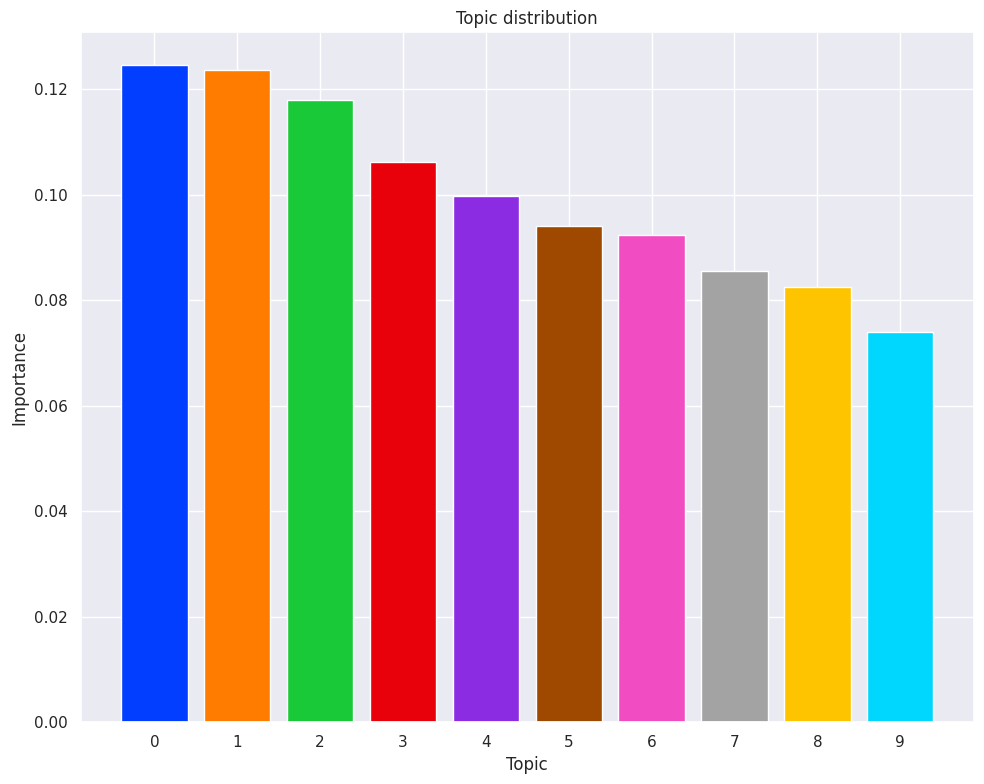

In [18]:
plsa_vis = Visualize(plsa_res)
fig, ax = plt.subplots()
plsa_vis.topics(ax)
fig.tight_layout()

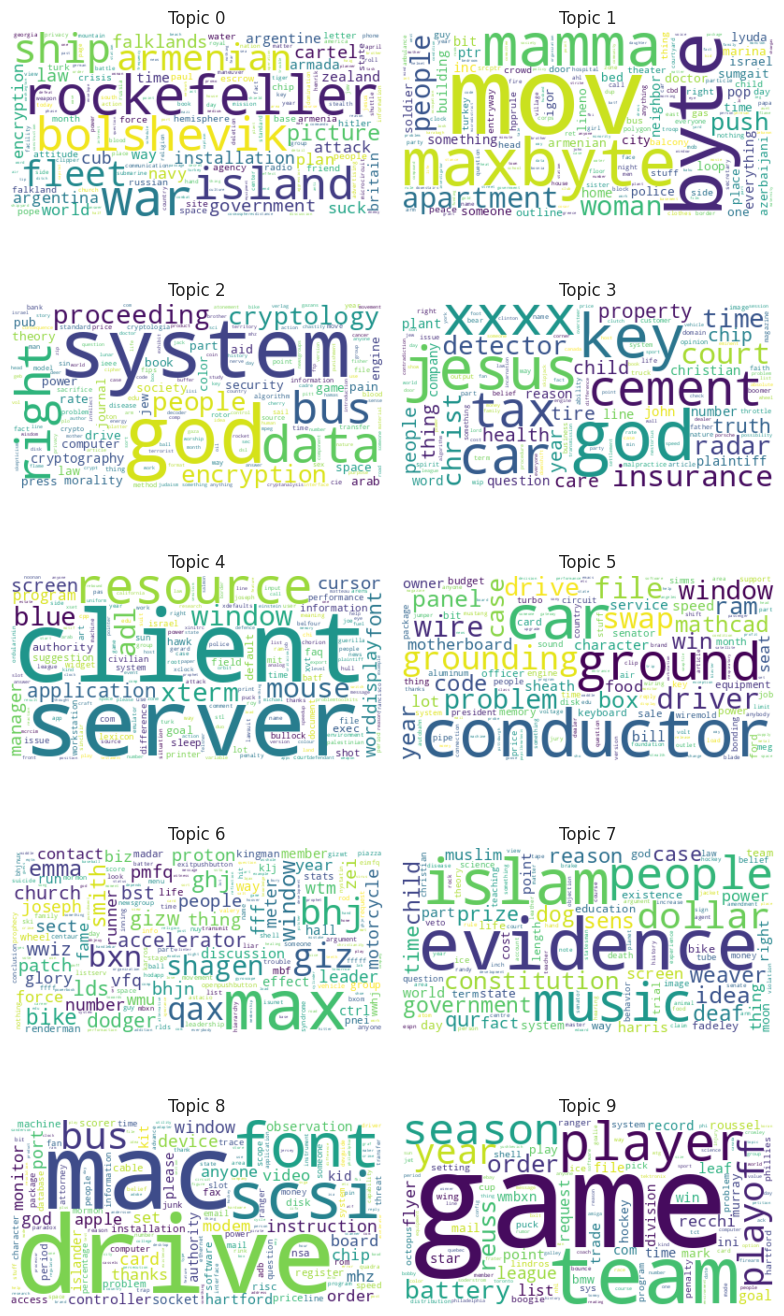

In [22]:
fig = plt.figure(figsize=(8, 14), dpi=100)
plsa_vis.wordclouds(fig)
plt.show()


morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)


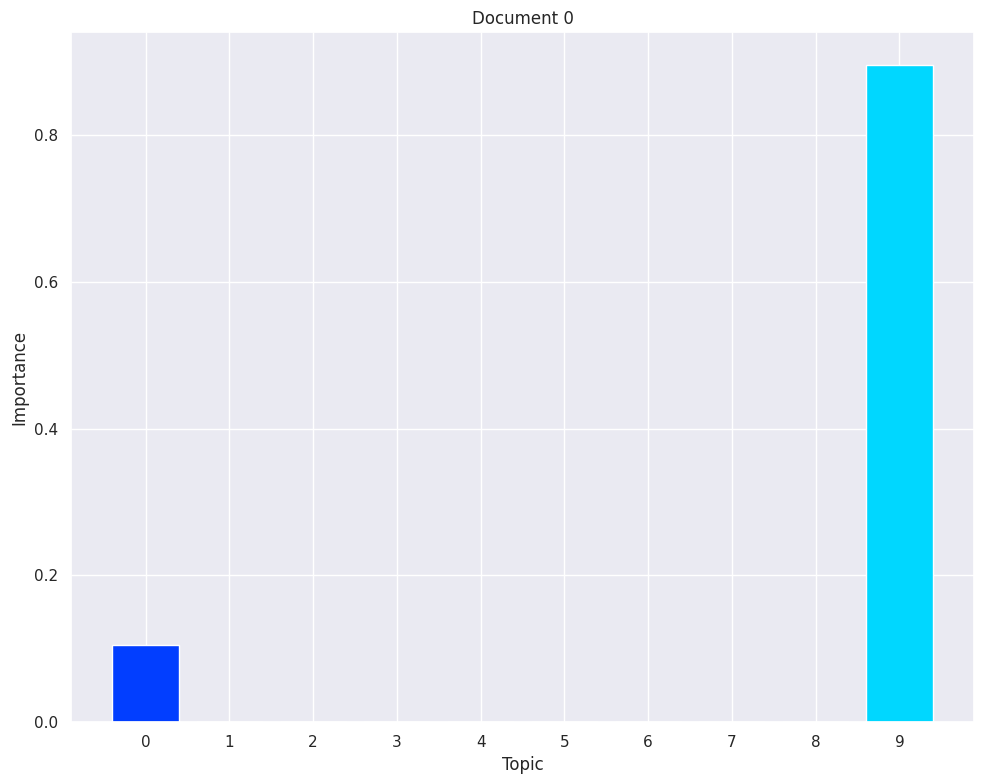

In [23]:
print(plsa_corpus.raw[0])
fig, ax = plt.subplots()
plsa_vis.topics_in_doc(0, ax)
fig.tight_layout()

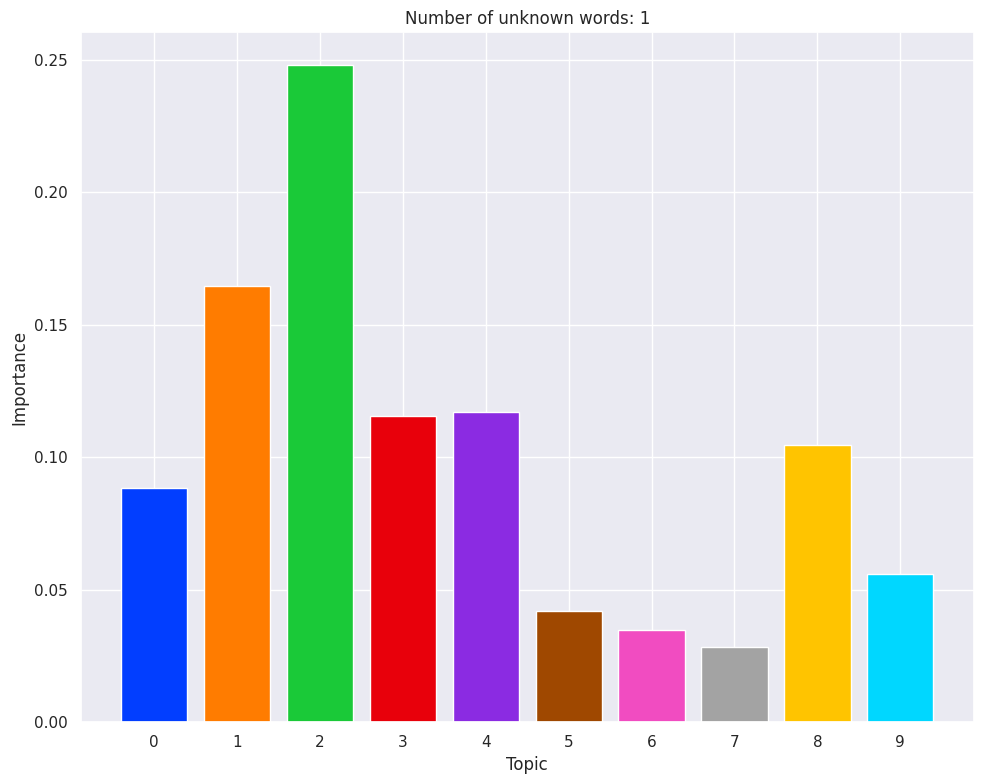

In [24]:
new_doc = (
    "Similar to a principal component analysis, the singular value decomposition "
    "If you’re familiar with this statistical method, encoding the original data set with these latent "
    "features using latent semantic analysis will minimize its dimensionality. "
    "These latent features correspond to the original text data’s subjects."
)

fig, ax = plt.subplots()
plsa_vis.prediction(new_doc, ax)
fig.tight_layout()

# Latent Dirichlet Allocation (LDA)

In [25]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(
    10, doc_topic_prior=None, topic_word_prior=None, n_jobs=-1, random_state=42
)
lda.fit(X)

/usr/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

,n_components,10
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


In [26]:
lda.perplexity(X)

np.float64(36436.49692215316)

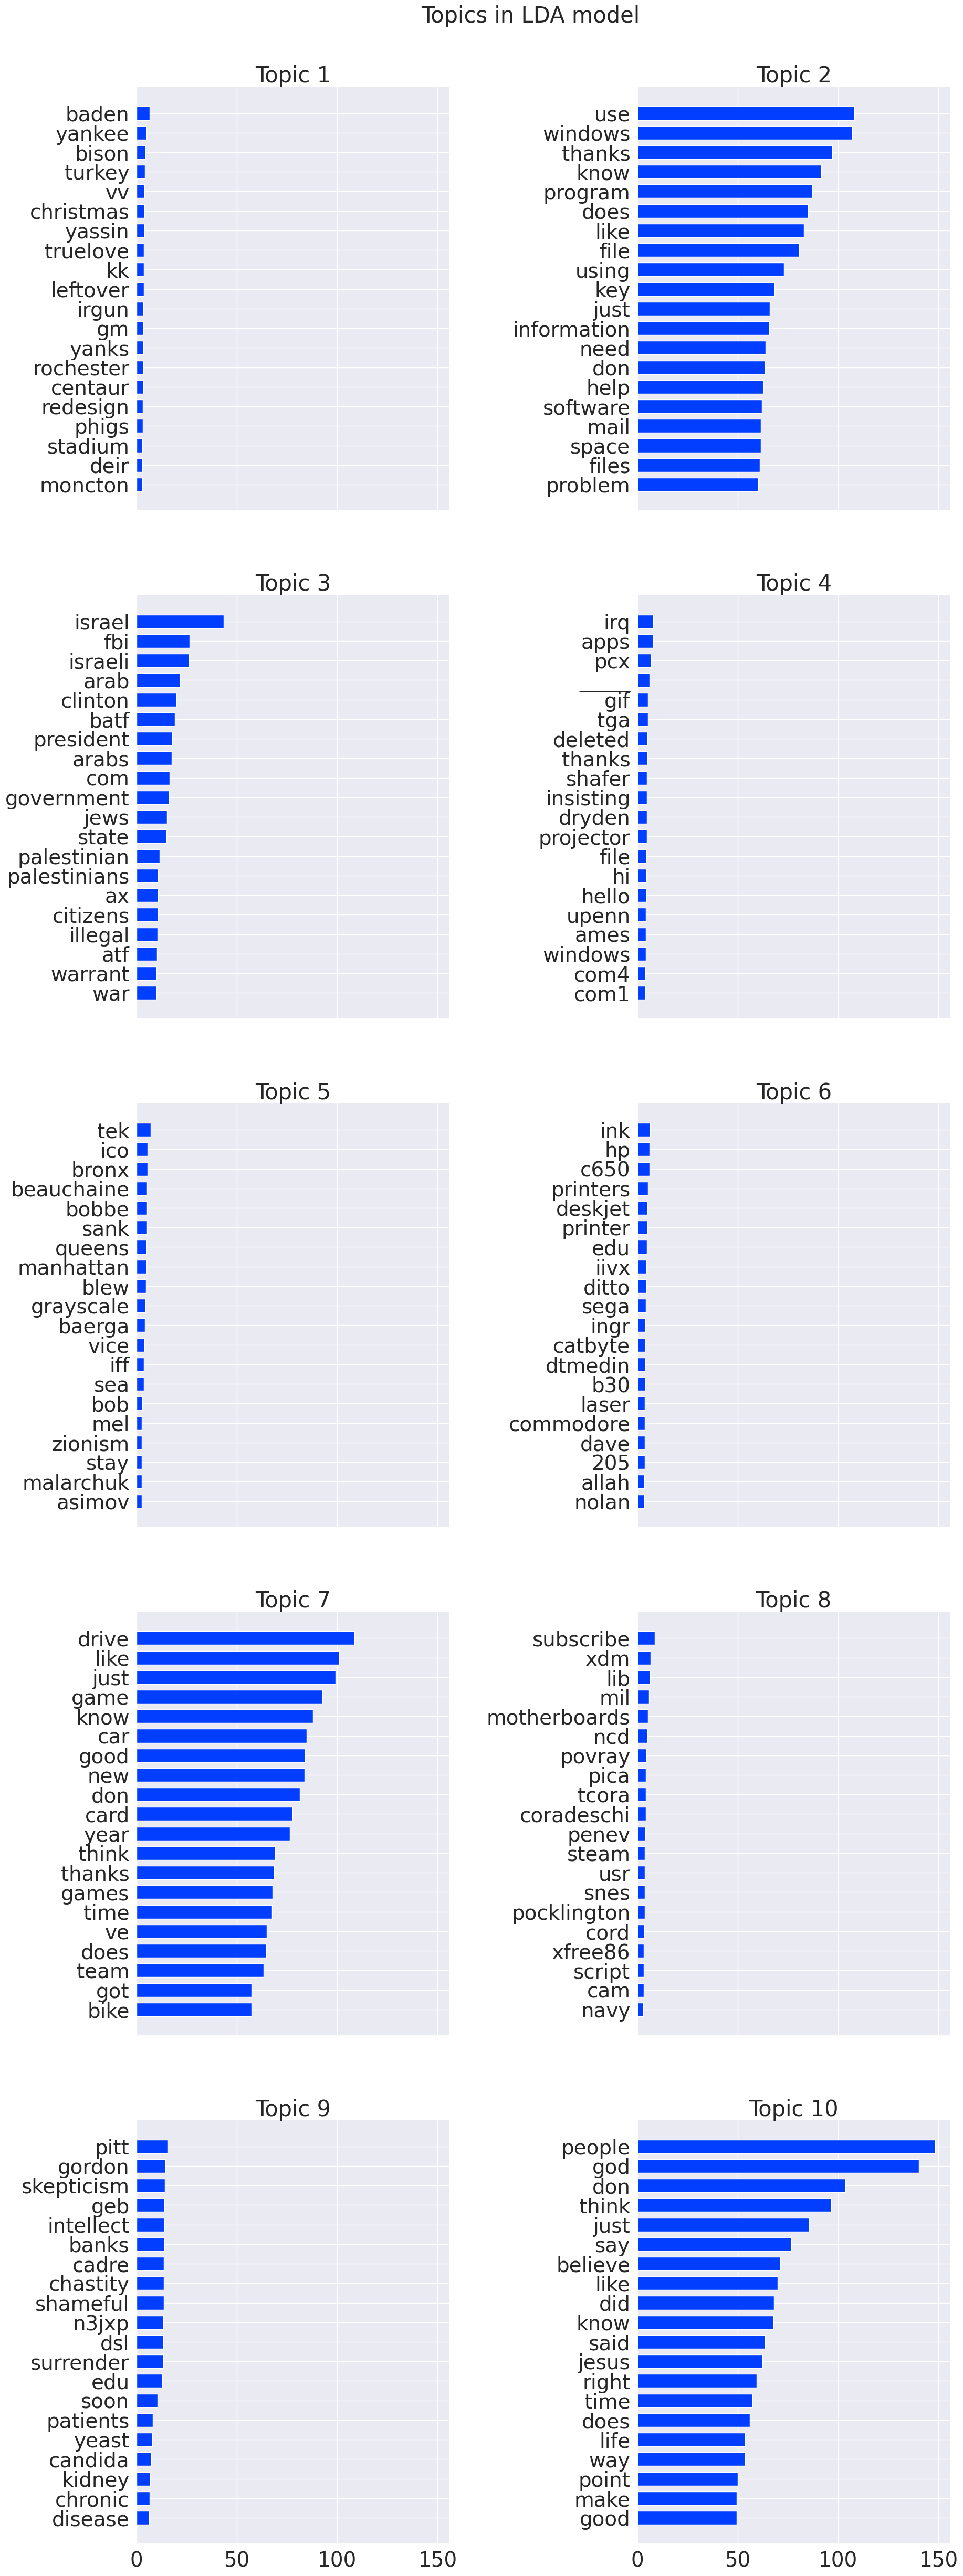

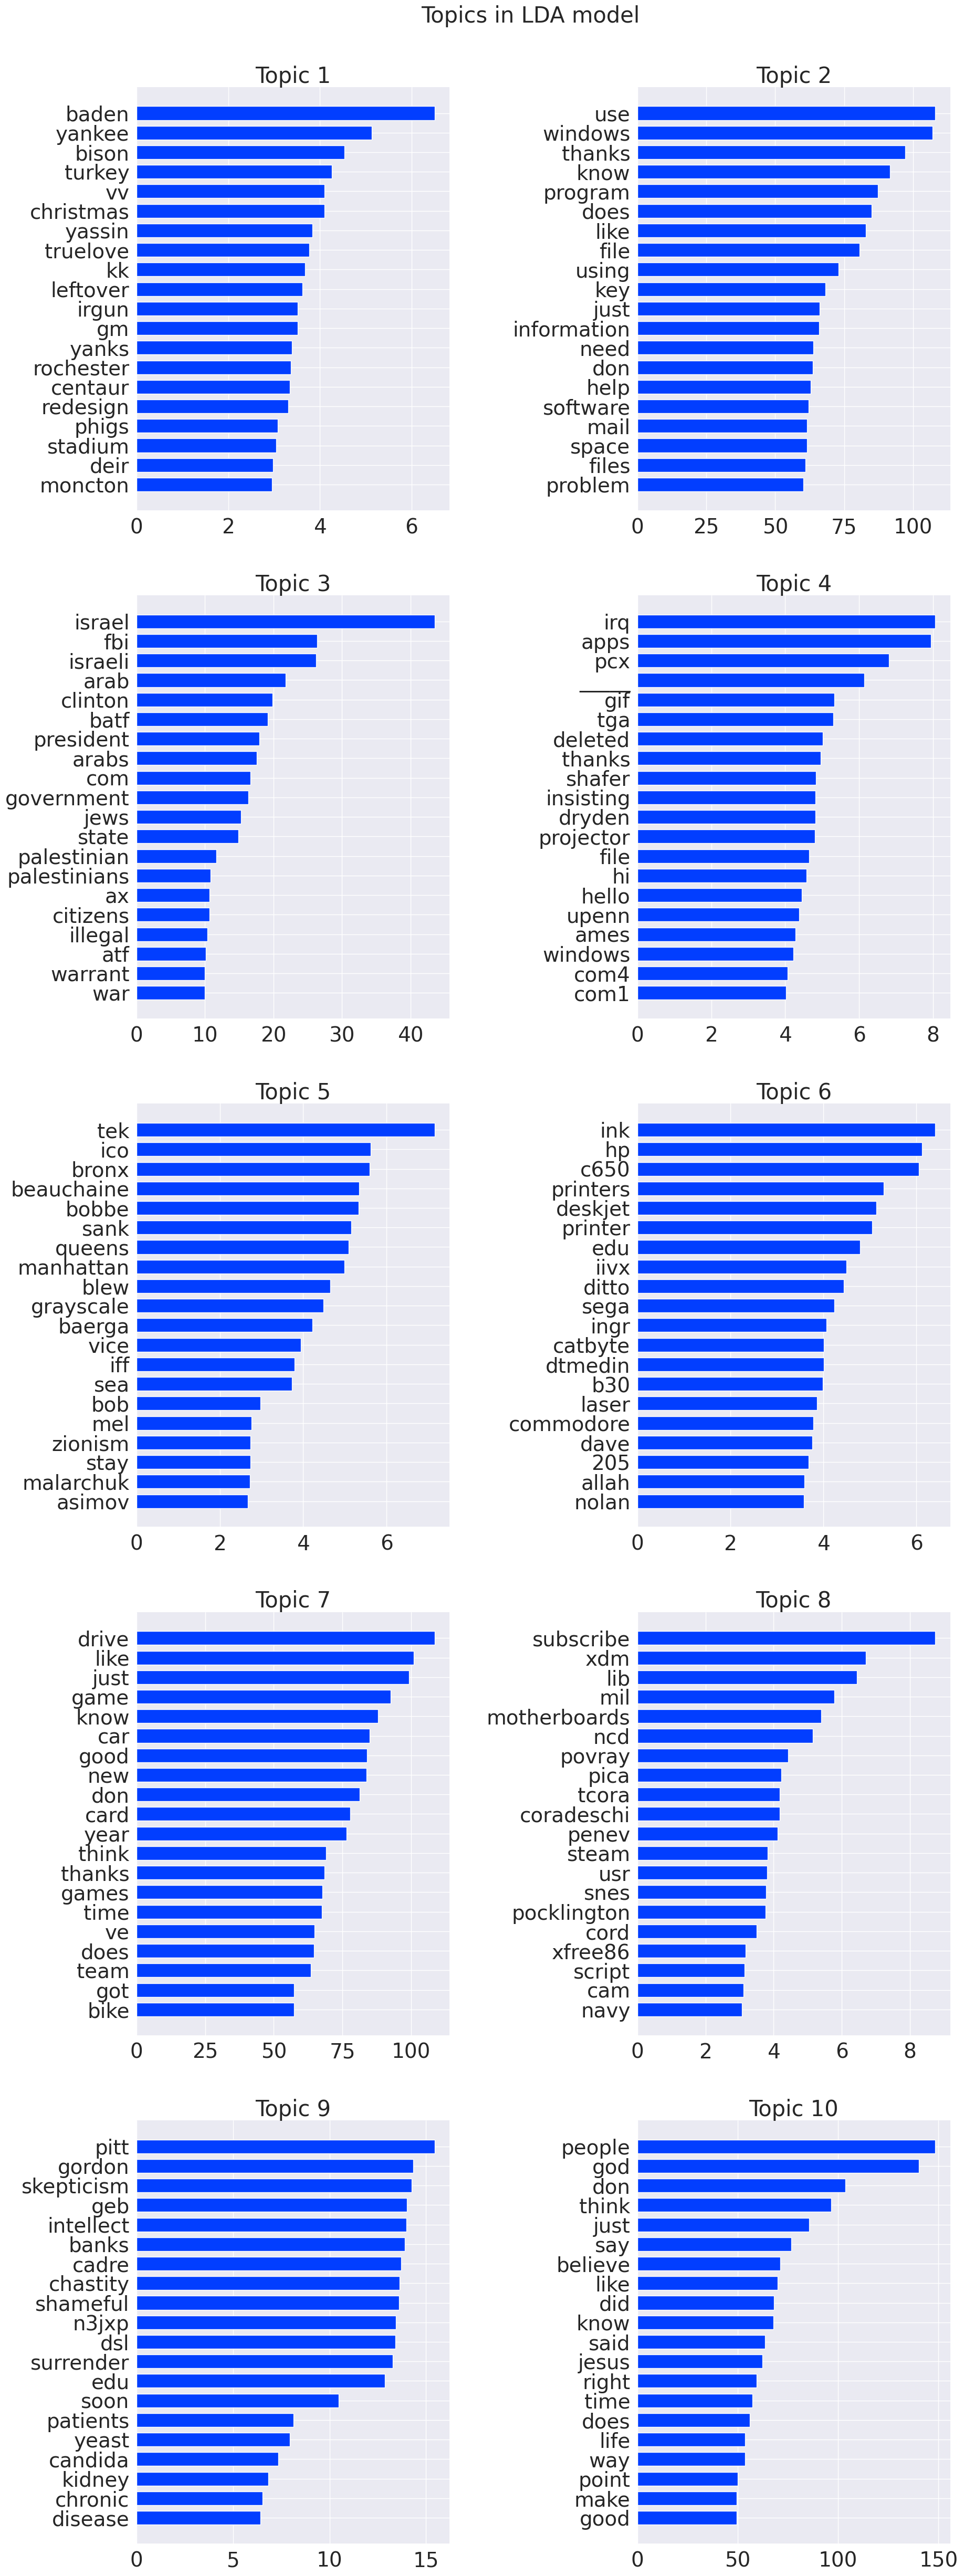

In [34]:
n_top_words = 20

def plot_top_words(model, feature_names, n_top_words, title, sharex=True):
    fig, axes = plt.subplots(5, 2, figsize=(20, 52), sharex=sharex)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=28)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=30)

    plt.subplots_adjust(top=0.95, bottom=0.05, wspace=0.6, hspace=0.2)
    plt.show()


plot_top_words(lda, feature_names, n_top_words, "Topics in LDA model")
plot_top_words(lda, feature_names, n_top_words, "Topics in LDA model", False)

In [63]:
new_doc_tfidf = vectorizer.transform([new_doc])
new_doc_prob = lda.transform(new_doc_tfidf)

for topic, prob in sorted(enumerate(lda.transform(new_doc_tfidf)[0]), key = lambda x: -x[1]):
    print(f"Topic {topic + 1}: {prob:.4}")

Topic 2: 0.6136
Topic 10: 0.187
Topic 3: 0.061
Topic 1: 0.01978
Topic 7: 0.01977
Topic 4: 0.01977
Topic 9: 0.01977
Topic 5: 0.01977
Topic 6: 0.01977
Topic 8: 0.01977
